# Self-Driving Car: Vehicle Detection and Tracking
### Daniel Wolf
### February 2017


The goals / steps of this project are the following:
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Apply a color transform and append binned color features, as well as histograms of color, to the HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


In [1]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog

import matplotlib.pyplot as plt
%matplotlib inline
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline

from scipy.ndimage.measurements import label


# Train a classifier

### Feature Extraction functions

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

    


In [3]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [4]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [5]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # Since reading PNG files, need to convert from 0-1 to 0-255
        image = np.uint8(image*255)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


In [6]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    example_img = np.uint8(example_img*255)
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    


### Read data, extract features, and train SVC

In [7]:
# Read in pictures of cars and notcars
images = glob.glob('data/*.png')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)


In [8]:
# Data Exploration

data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])



Your function returned a count of 8792  cars and 9666  non-cars
of size:  (64, 64, 3)  and data type: uint8


In [9]:
# Systematic approach to feature selection
# Skip this cell once optimal features are found

#params = {'color_space':('YUV','LUV'),#('RGB', 'HSV', 'LUV', 'HLS', 'YUV'), 'YCrCb'), 
#          'orient':(9), 
#          'pix_per_cell':(8,12,16), 
#          'cell_per_block':(2,4,1), 
#          'hog_channel':(0,1,2,'ALL'), 
#          'spatial_size':((8, 8),(16, 16)),#,(32, 32)), 
#          'hist_bins':[16,32], #[8,16,32]}
#          'spatial_feat':[True,False],
#          'hist_feat':[True,False]}

#print('spatial_feat,hist_feat,color_space,orient,pix_per_cell,cell_per_block,
#       hog_channel,spatial_size,hist_bins,Feature_vector_length,Accuracy')

#for spatial_feat in params['spatial_feat']:
#    for hist_feat in params['hist_feat']:
#        for color_space in params['color_space']:
#    for pix_per_cell in params['pix_per_cell']:
#        for cell_per_block in params['cell_per_block']:
#            for hog_channel in params['hog_channel']:
#                for spatial_size in params['spatial_size']:
#                    for hist_bins in params['hist_bins']:
#                        
#                        # Extract features
#                        car_features = extract_features(cars, color_space=color_space, 
#                            spatial_size=spatial_size, hist_bins=hist_bins, 
#                            orient=orient, pix_per_cell=pix_per_cell, 
#                            cell_per_block=cell_per_block, 
#                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                            hist_feat=hist_feat, hog_feat=hog_feat)
#                        notcar_features = extract_features(notcars, color_space=color_space, 
#                            spatial_size=spatial_size, hist_bins=hist_bins, 
#                            orient=orient, pix_per_cell=pix_per_cell, 
#                            cell_per_block=cell_per_block, 
#                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                            hist_feat=hist_feat, hog_feat=hog_feat)
#                        
#                        X = np.vstack((car_features, notcar_features)).astype(np.float64)
#                        # Fit a per-column scaler
#                        X_scaler = StandardScaler().fit(X)
#                        # Apply the scaler to X
#                        scaled_X = X_scaler.transform(X)
#                        
#                        # Define the labels vector
#                        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
#                        
#                        # Split up data into randomized training and test sets
#                        rand_state = np.random.randint(0, 100)
#                        X_train, X_test, y_train, y_test = train_test_split(
#                            scaled_X, y, test_size=0.2, random_state=rand_state)
#                        
#                        # Use a linear SVC
#                        svc = LinearSVC()
#                        svc.fit(X_train, y_train)
#                        # Check the score of the SVC
#                        #print('Test_Accuracy ', round(svc.score(X_test, y_test), 4))
#                        print(spatial_feat,',',hist_feat,',',color_space,',',orient,',',pix_per_cell,',',cell_per_block,',',
#                              hog_channel,',',spatial_size,',',hist_bins,',',len(X_train[0]),',',
#                              round(svc.score(X_test, y_test), 4))
#                        # Check the prediction time for a single sample


In [10]:
# Parameter selection aligns to fewest number of features with at least 99% accuracy
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 1 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [11]:
# Extract features
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


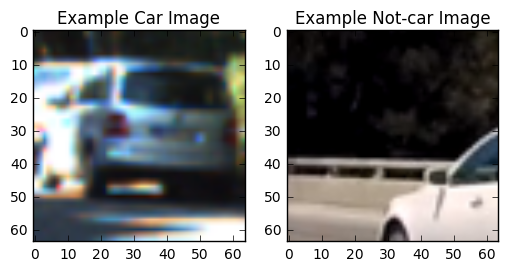

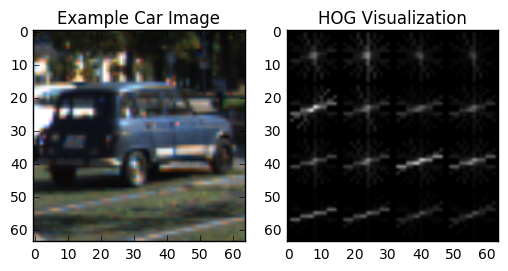

In [12]:
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
car_image = np.uint8(car_image*255)
notcar_image = mpimg.imread(notcars[notcar_ind])
notcar_image = np.uint8(notcar_image*255)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
image = np.uint8(image*255)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')


In [13]:
# Stack the training features
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))


Feature vector length: 1296


In [14]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


1.68 Seconds to train SVC...
Test Accuracy of SVC =  0.993


## Apply to images

In [15]:
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


In [16]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [17]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        decision = clf.decision_function(test_features)
        #7) If positive (prediction == 1) then save the window
#        if prediction == 1:
        if decision > 0:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
 

In [18]:
# Pipeline to define the windows that will be searched and then search them (two functions above)
def window_pipeline(image):
    
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    #image = image.astype(np.float32)/255
    
    # Define the windows that will be searched for car images
    # Note that the actual y range goes lower than what is defined here
    xy_windows = [(64,64),(88,88),(126,126),(276,276)]
    y_start_stops = [[415,470],[395,470],[400,487],[400,560]] # Min and max in y to search in slide_window()
    x_start_stops = [[150,1050],[150,1050],[None,None],[None,None]] # Min and max in y to search in slide_window()
    xy_overlaps = [[0.8,0.8],[0.8,0.8],[0.8,0.8],[0.8,0.8]]
    
    hot_windows = []
    
    # Call functions for defining search bounding boxes and determining which have car images
    for i in range(0,len(xy_windows)):
        windows = slide_window(image, x_start_stop=x_start_stops[i], y_start_stop=y_start_stops[i], 
                            xy_window=xy_windows[i], xy_overlap=xy_overlaps[i])
        
        hot_windows += search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
    
    return hot_windows


In [19]:
# Function for generating a heatmap
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap

# Function for applying threshold
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# Function for returning bounding box coordinates based on the labels
def get_bboxes(labels):
    # Iterate through all detected cars
    bbox = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox.append([(np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))])
        
    return bbox
    
# Function for extracting bboxes from bbox tuple during video processing
def extract_bboxes(bbox_tuples):
    bboxes = []
    for bbox_tuple in bbox_tuples:
        bboxes.append(bbox_tuple[0])
    return bboxes
    
# Function for drawing the label boxes on the final image
def draw_bboxes(img, bbox, color=(0, 0, 255), thick=6):
    for box in bbox:
        # Draw the box on the image
        cv2.rectangle(img, box[0], box[1], color, thick)
    # Return the image
    return img


test_images\test1.jpg
Labeled bboxes:  [[(810, 395), (951, 516)]]


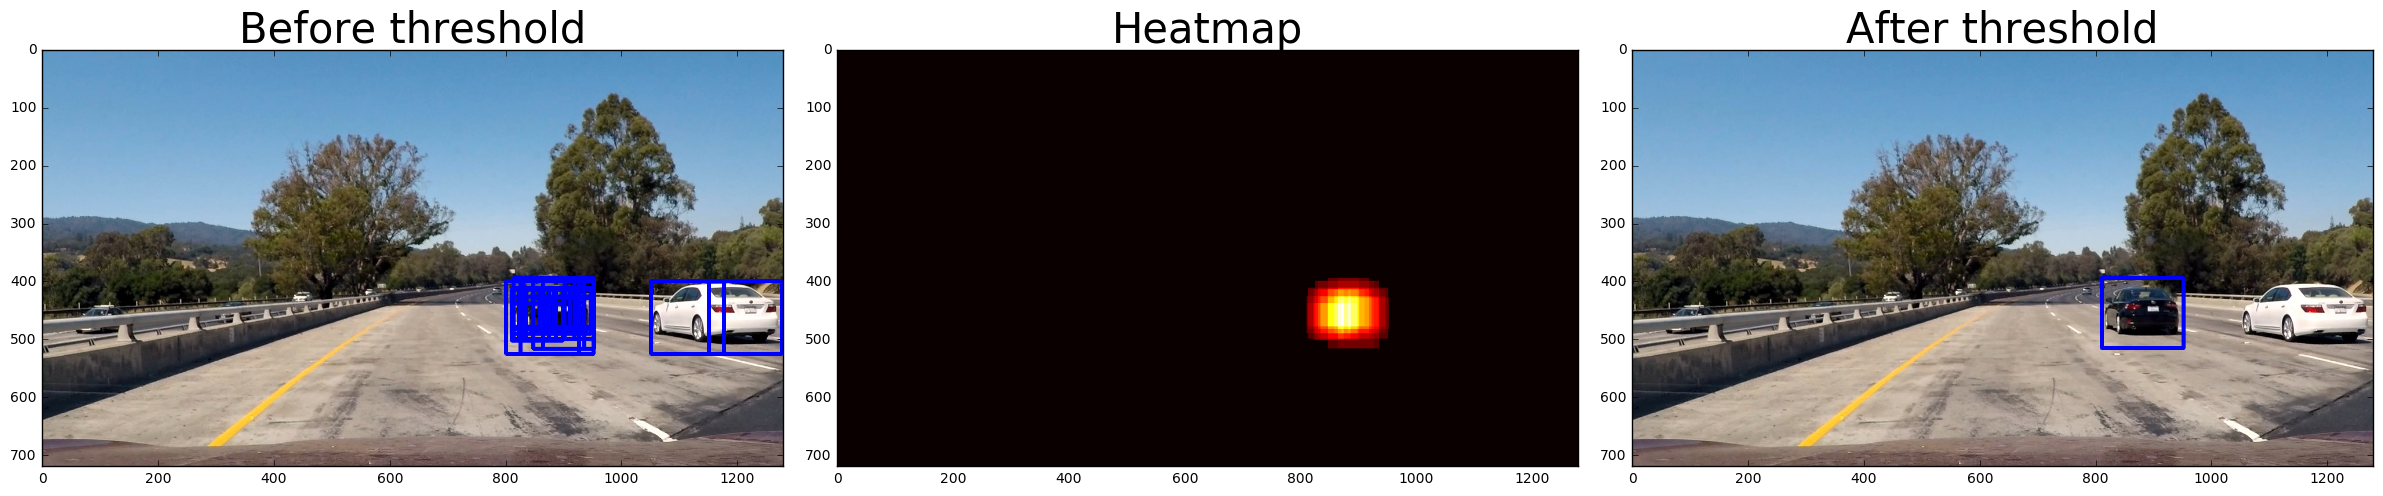

test_images\test2.jpg
Labeled bboxes:  []


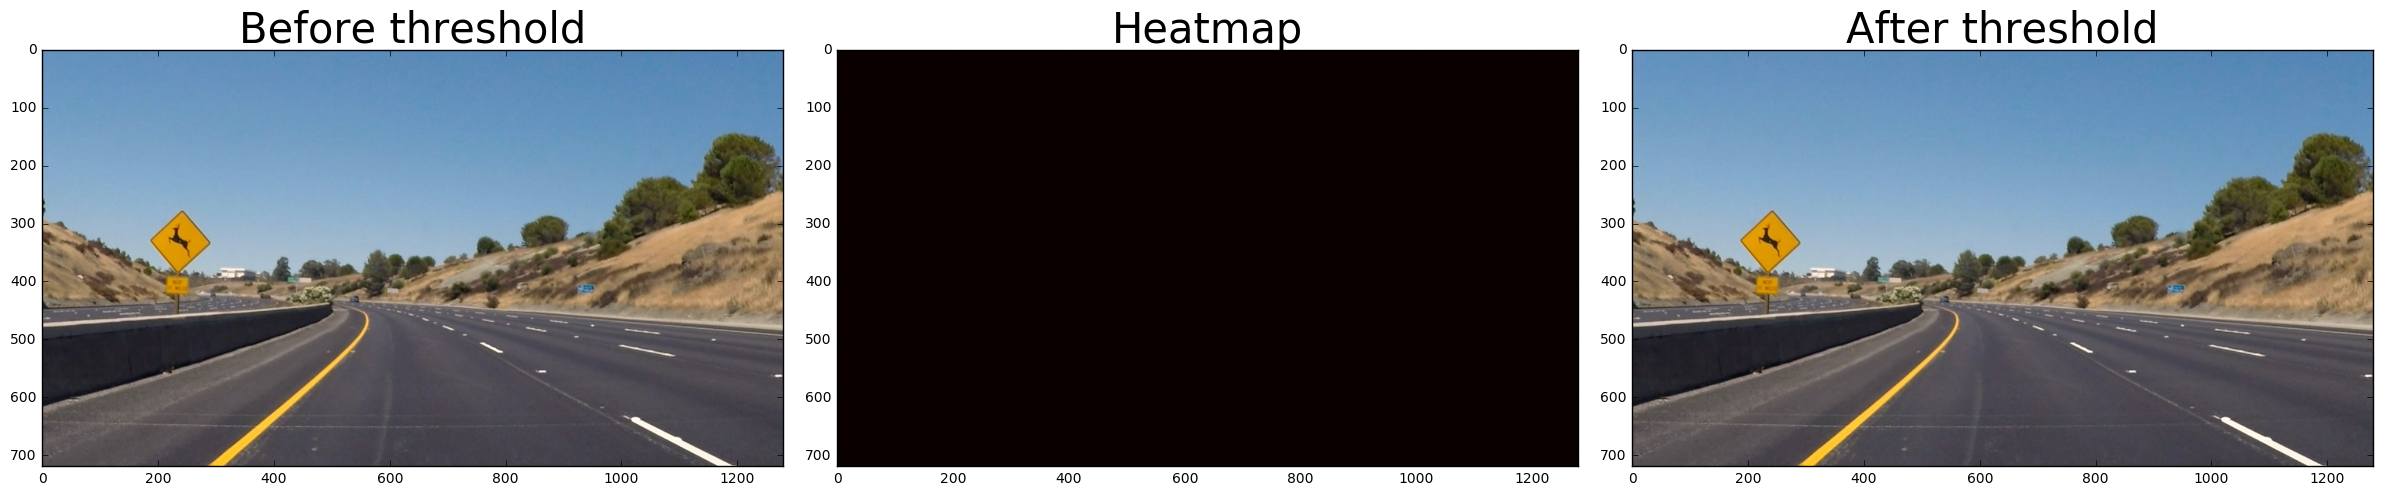

test_images\test3.jpg
Labeled bboxes:  [[(930, 427), (1029, 516)]]


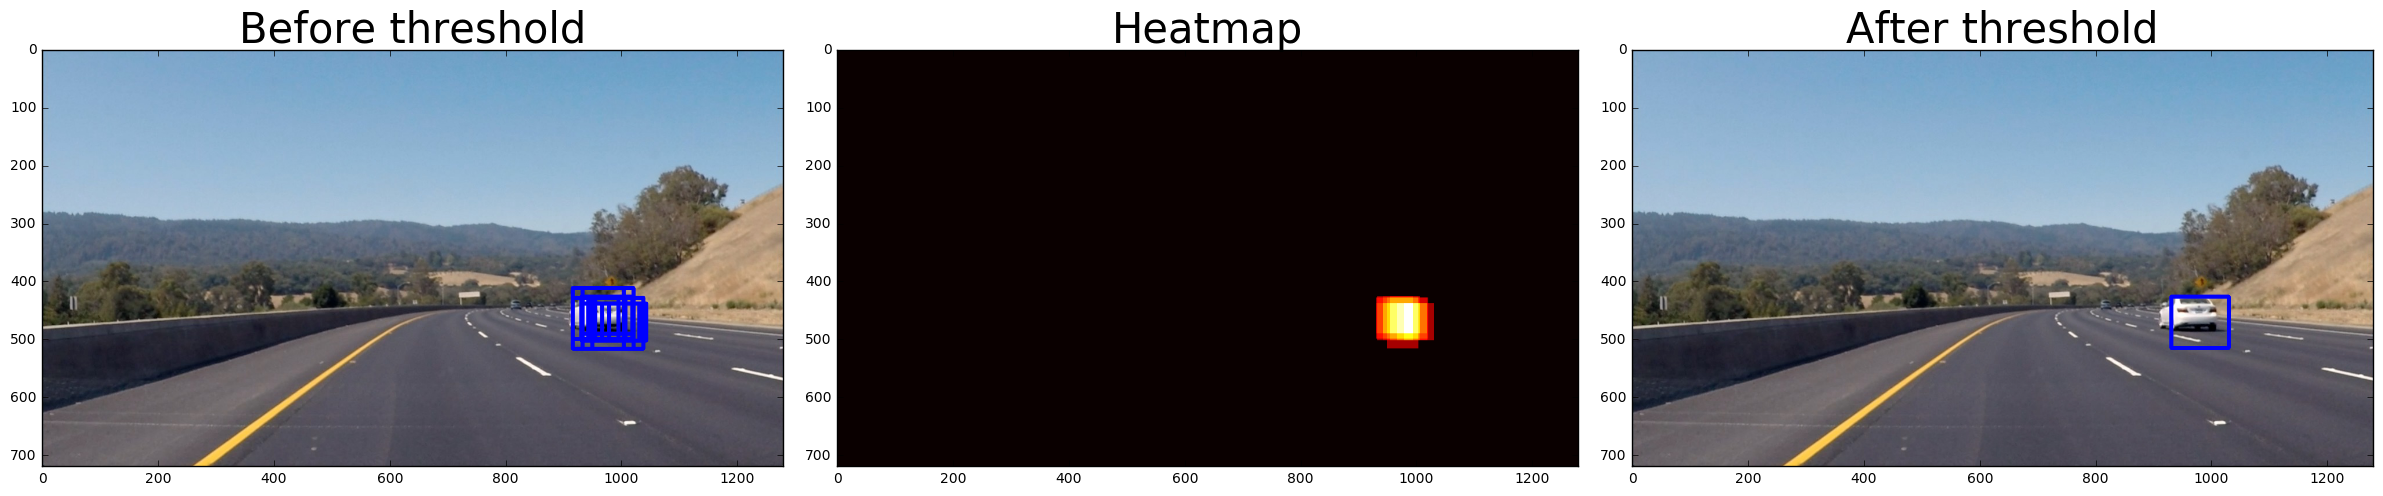

test_images\test4.jpg
Labeled bboxes:  [[(810, 395), (951, 516)], [(1125, 400), (1175, 525)]]


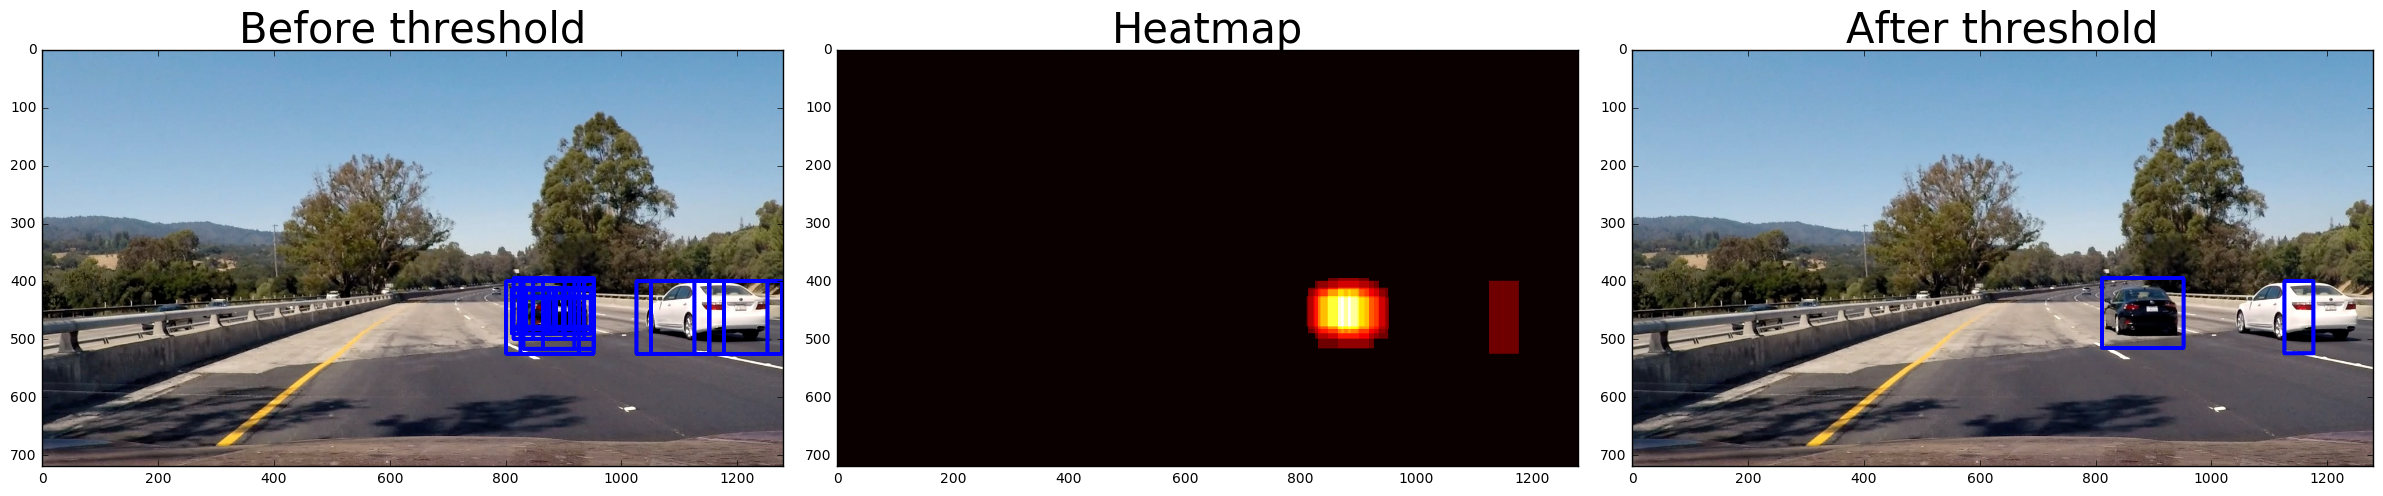

test_images\test5.jpg
Labeled bboxes:  [[(813, 400), (950, 516)], [(1150, 400), (1200, 525)]]


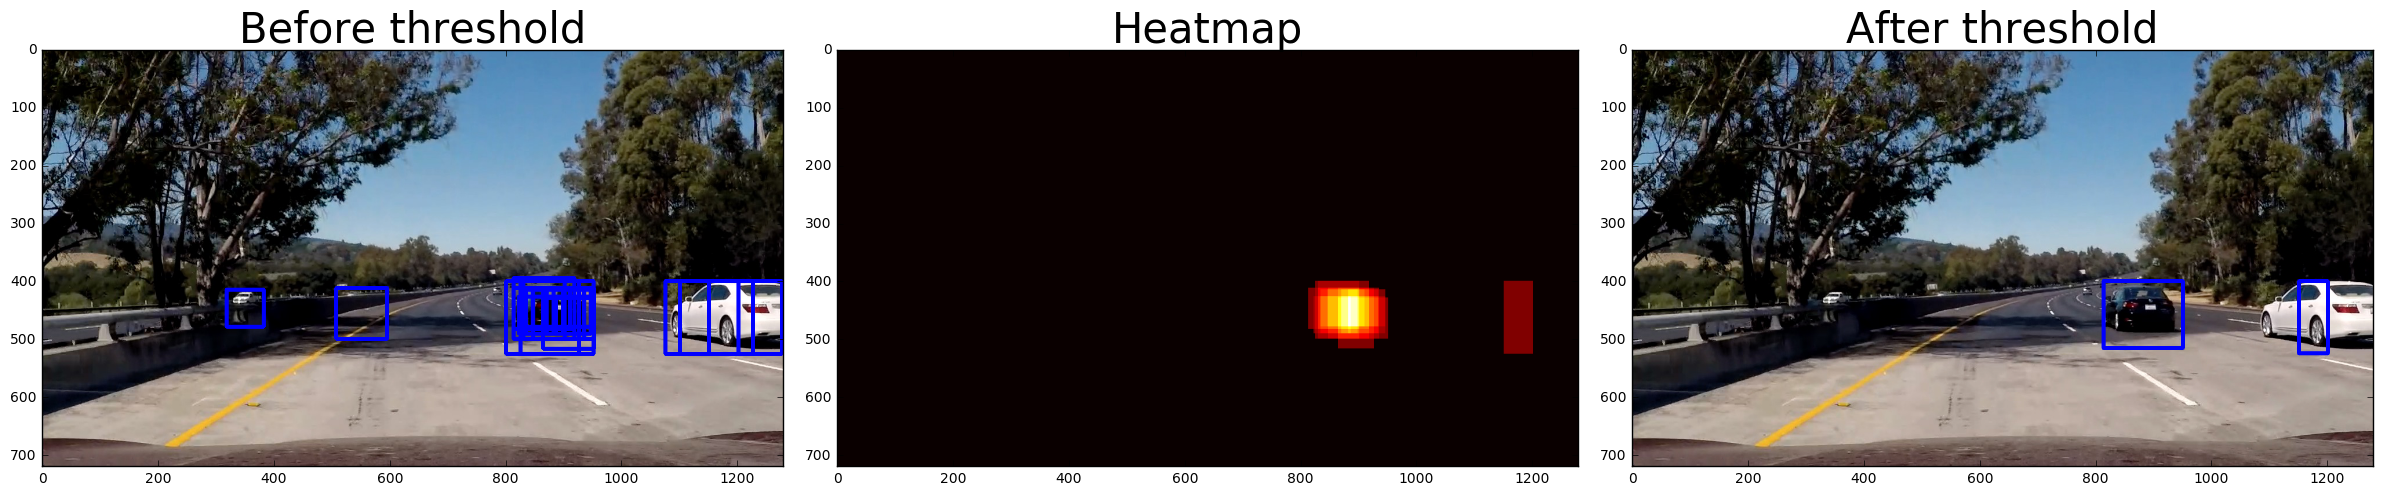

test_images\test6.jpg
Labeled bboxes:  [[(810, 395), (951, 525)], [(1100, 400), (1125, 525)], [(1014, 412), (1089, 502)]]


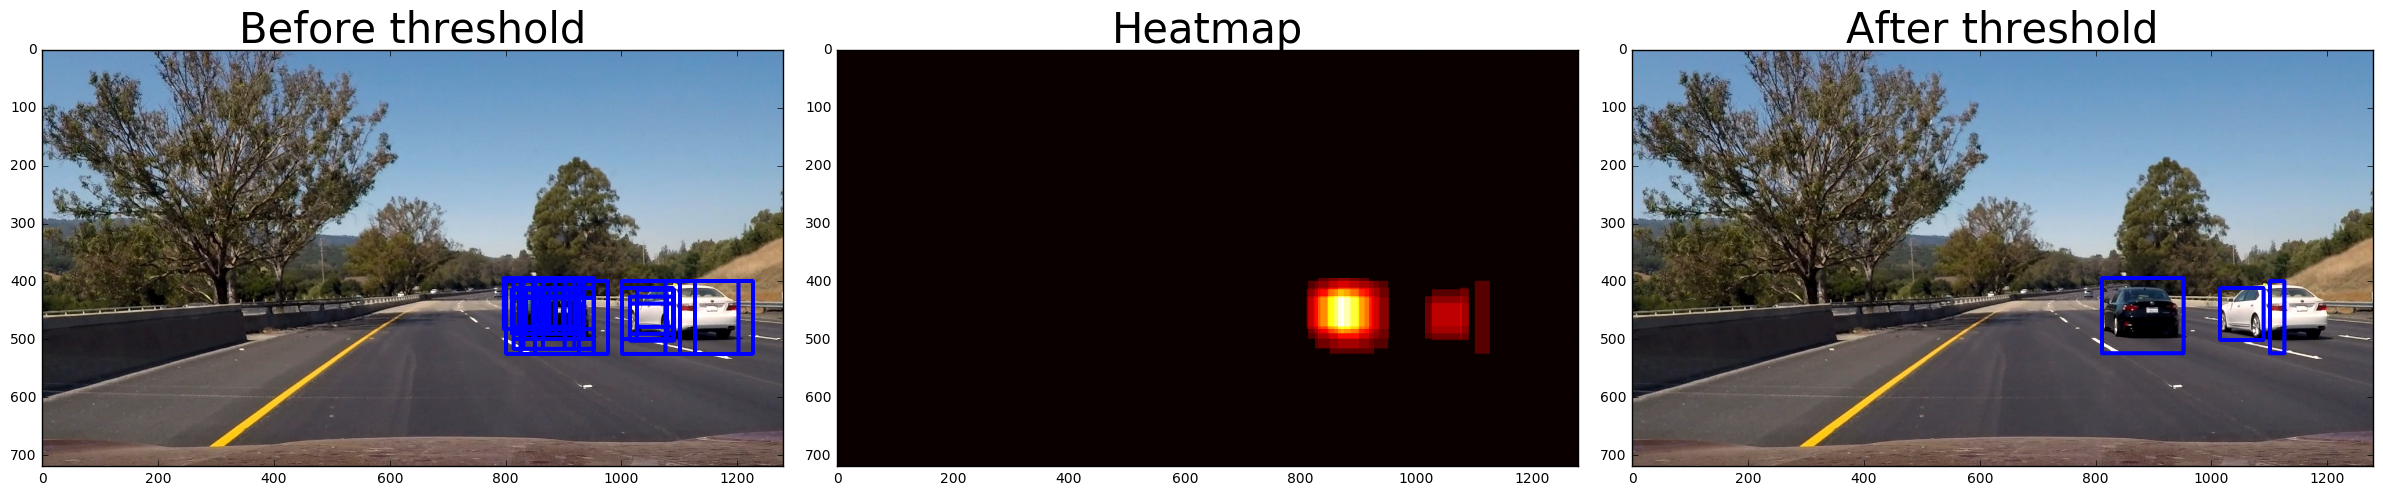

In [20]:
images = glob.glob('test_images/test*.jpg')

# Cycle through each test image
for fname in images:
    print(fname)
    image = mpimg.imread(fname)
    
    # Call window pipeline to get windows with cars in them
    hot_windows = window_pipeline(image)
    
    # Convert the windows into a heatmap for thresholding purposes
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heat, hot_windows)
    display_heat = heatmap
    
    # There need to be more than 2 overlapping hot windows for it to qualify as a car image (remove false positives)
    threshold = 2
    heatmap = apply_threshold(heatmap, threshold)
    
    # Identify a label for each car on the heatmap
    labels = label(heatmap)
    
    # Turn the labels into bboxes
    labeled_bboxes = get_bboxes(labels)
    print("Labeled bboxes: ", labeled_bboxes)
    
    # Draw bounding boxes on a copy of the image
    draw_img = draw_bboxes(np.copy(image), labeled_bboxes)
    
    # Visualize the results
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    ax1.set_title('Before threshold', fontsize=30)
    window_img = draw_bboxes(np.copy(image), hot_windows, color=(0, 0, 255), thick=6)                    
    ax1.imshow(window_img)
    ax2.set_title('Heatmap', fontsize=30)
    ax2.imshow(display_heat, cmap='hot')
    ax3.set_title('After threshold', fontsize=30)
    ax3.imshow(draw_img)
    plt.show()
    



# Apply pipeline to video

In [21]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# Install ffmpeg with:
#import imageio
#imageio.plugins.ffmpeg.download()


In [22]:
# Define classes to record recent heatmaps and bboxes to improve robustness
import collections
class Heatmap():
    def __init__(self):
        # check for first frame of the video
        self.first = True
        # values of the last 10 heatmaps
        self.recent = collections.deque(maxlen=10)

class BBox():
    def __init__(self):
        # check for first frame of the video
        self.first = True
        # values of the last n bboxes
        self.recent = []


In [23]:
# function that verifies a bbox is valid and averages it with prior boxes
import math
def average_bbox(bboxes, img_width):
    
    # bbox_glob.recent holds a tuple that includes
    # 1 - Bbox top/left and bottom/right corners
    # 2 - Deque collection of recent bbox widths (used for smoothing width frame to frame)
    # 3 - Deque collection of recent bbox heights
    # 4 - Counter of how many frames since this bbox was found (bbox will stay on for some frames even if not found)
    
    # Iterate through the bboxes identified in the most recent image frame
    for cur in bboxes:
        # Set to tru if current bbox is found in recent bboxes
        found = False
        # Iterate through the global recent bboxes looking for a match
        for rec in bbox_glob.recent:
            # Arithmetic to determine the centers, heights, and widths of the current bbox and recent bbox
            # recb holds the recent bbox
            recb = rec[0]
            recent_width = int(recb[1][0]-recb[0][0])
            recent_height = int(recb[1][1]-recb[0][1])
            recent_center = tuple((recent_width / 2 + recb[0][0], recent_height / 2 + recb[0][1]))
            current_width = int(cur[1][0]-cur[0][0])
            current_height = int(cur[1][1]-cur[0][1])
            current_center = tuple((current_width / 2 + cur[0][0], current_height / 2 + cur[0][1]))
            
            # Arithmetic to determine how far apart the centers are between current and recent bbox
            dist_x = int(current_center[0]) - int(recent_center[0])
            dist_y = int(current_center[1]) - int(recent_center[1])
            
            # Check if current bbox is close enough to recent bbox
            if math.sqrt(dist_x**2 + dist_y**2) < 120:
                # If it is close, then update the recent bbox tuple with the latest bbox info
                rec[1].append(current_width)
                width = max(rec[1])
                rec[2].append(current_height)
                height = sum(rec[2]) / float(len(rec[2]))
                
                # Apply a weighting such that the new bbox pulls the recent bbox by 1/5 of its distance apart
                recent_center = tuple((dist_x / 5 + recent_center[0], dist_y / 5 + recent_center[1]))
                
                # Calculate the new bbox and append it to the recent bboxes
                recent_topleft = tuple((int(recent_center[0] - width/2), int(recent_center[1] - height/2)))
                recent_bottomright = tuple((int(recent_center[0] + width/2), int(recent_center[1] + height/2)))
                recent = tuple((recent_topleft, recent_bottomright))
                bbox_glob.recent.append(tuple((recent,rec[1],rec[2],[0])))
                # Don't forget to remove the last bbox!
                bbox_glob.recent.remove(rec)
                found = True
            
        # If the current bbox is not close to any bboxes.recent, add it recent bboxes
        if not found:
            # Set up the tuple for the new bbox
            widths = collections.deque(maxlen=80)
            widths.append(cur[1][0]-cur[0][0])
            heights = collections.deque(maxlen=80)
            heights.append(cur[1][1]-cur[0][1])
            bbox_glob.recent.append(tuple((cur, widths, heights, [0])))
    
    # Check whether any existing bboxes need to be removed
    for rec in bbox_glob.recent:
        # recb holds the recent bbox
        recb = rec[0]
        # Check if enough frames have passed without seeing this frame
        if rec[3][0] >= 50:
            bbox_glob.recent.remove(rec)
        rec[3][0] += 1
            
    bboxes = bbox_glob.recent
    return bboxes


In [24]:
# Pipeline for video processing
def process_image(image):
    
    # Call window pipeline to get windows with cars in them
    hot_windows = window_pipeline(image)
    
    # Convert the windows into a heatmap for thresholding purposes
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    current_hm = add_heat(heat, hot_windows)
    # There need to be more than 2 overlapping hot windows for it to qualify as a car image (remove false positives)
    threshold = 2
    current_hm = apply_threshold(current_hm, threshold)
    
    # Each heatmap counts for one towards the threshold for number of prior frames
    current_hm[current_hm > 0] = 1
    
    # Append to the last 10 heatmaps and sum
    heatmaps.recent.append(current_hm)
    heatmap = sum(heatmaps.recent)
    
    # The heatmap needs to be in more than 8/10 prior frames (remove false positives)
    threshold = 8
    heatmap = apply_threshold(heatmap, threshold)
    
    # Identify a label for each car on the heatmap
    labels = label(heatmap)
    
    # Turn the labels into bboxes
    bboxes = get_bboxes(labels)
    
    # bbox verification and averaging
    bboxes_tuple = average_bbox(bboxes, image.shape[1])
    
    # Extract the bboxes out of the bbox tuple
    bboxes = extract_bboxes(bboxes_tuple)
    
    # Draw bounding boxes on a copy of the image
    output = draw_bboxes(np.copy(image), bboxes)
    
    return output

In [25]:
# Initialize heatmap and bounding box class
heatmaps = Heatmap()
bbox_glob = BBox()

# Process the video
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) # Send each frame to process_image()
%time white_clip.write_videofile('project_video_output.mp4', audio=False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [25:06<00:01,  1.16s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 25min 7s


In [26]:
# Training Data Sources:
# - www.gti.ssr.upm.es/data/Vehicle_database.html
# - http://www.cvlibs.net/datasets/kitti/
# - project video itself
# Udacity annotated data available here: https://github.com/udacity/self-driving-car/tree/master/annotations
# This dataset includes a CSV file with bounding box corners